In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score, log_loss, brier_score_loss, roc_auc_score,
    precision_recall_fscore_support, roc_curve
)
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
from sklearn.calibration import calibration_curve

RANDOM_SEED = 0
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [ ]:
df = pd.read_csv('/content/Social_Network_Ads.csv')
print("Dataset Preview")
display(df.head())

Dataset Preview


,User ID,Gender,Age,EstimatedSalary,Purchased
0,15624510,Male,19,19000,0
1,15810944,Male,35,20000,0
2,15668575,Female,26,43000,0
3,15603246,Female,27,57000,0
4,15804002,Male,19,76000,0


In [ ]:
print("Columns:", df.columns.tolist())

Columns: ['User ID', 'Gender', 'Age', 'EstimatedSalary', 'Purchased']


In [ ]:
from re import X
x=df[['Age','EstimatedSalary']].values
y=df['Purchased'].values
X_trainval, X_test, y_trainval, y_test = train_test_split(x, y, test_size=0.2, random_state=RANDOM_SEED, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_trainval, y_trainval, test_size=0.2, random_state=RANDOM_SEED, stratify=y_trainval)
#Scaling Features
scaler = StandardScaler().fit(X_train)
X_train_s = scaler.transform(X_train)
X_val_s = scaler.transform(X_val)
X_test_s = scaler.transform(X_test)
#Tensor convertion
def to_tensor(x,y=None):
  x_t = torch.tensor(x,dtype=torch.float32).to(device)
  if y is None:
    return x_t
  y_t = torch.tensor(y,dtype=torch.float32).to(device)
  return x_t,y_t
X_train_t, y_train_t = to_tensor(X_train_s,y_train)
X_val_t, y_val_t = to_tensor(X_val_s,y_val)
X_test_t, y_test_t = to_tensor(X_test_s,y_test)
print("Train/val/Test sizes:", X_train_t.shape[0], X_val_t.shape[0], X_test_t.shape[0])


Train/val/Test sizes: 256 64 80


In [ ]:
batch_size = 32
train_loader = DataLoader(TensorDataset(X_train_t, y_train_t), batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(TensorDataset(X_val_t, y_val_t), batch_size=batch_size, shuffle=False)
test_loader  = DataLoader(TensorDataset(X_test_t, y_test_t), batch_size=batch_size, shuffle=False)

In [ ]:
class LogisticModel(nn.Module):
  def __init__(self, input_dim, output_dim):
    super().__init__()
    self.linear = nn.Linear(input_dim, 1)
  def forward(self,x):
    logits = self.linear(x).squeeze(-1)
    probs=torch.sigmoid(logits)
    return logits, probs

***Objective/Loss Functions***

In [ ]:
# BCE (stable): use logits version
def loss_bce(logits, y):
    return F.binary_cross_entropy_with_logits(logits, y)

# MSE on probabilities
def loss_mse(logits, y):
    probs = torch.sigmoid(logits)
    return F.mse_loss(probs, y)

# Centered covariance (L3-like) -> minimize negative covariance
def loss_neg_covariance(logits, y):
    probs = torch.sigmoid(logits)
    centered = (y - 0.5) * (probs - 0.5)
    return -4.0 * torch.mean(centered)

# Hinge loss (requires labels in {-1, +1})
def loss_hinge(logits, y):
    y_signed = (y * 2.0) - 1.0
    margin = 1.0 - y_signed * logits
    loss = torch.clamp(margin, min=0.0)
    return torch.mean(loss)

# Focal Loss (on BCE with logits): alpha * (1 - p_t)^gamma * BCE
class FocalLossLogits(nn.Module):
    def __init__(self, alpha=1.0, gamma=2.0):
        super().__init__()
        self.alpha = alpha
        self.gamma = gamma
    def forward(self, logits, y):
        bce = F.binary_cross_entropy_with_logits(logits, y, reduction='none')   # shape (batch,)
        # p_t = probability of the true class
        # Since BCE = -log(p_t) => p_t = exp(-BCE)
        p_t = torch.exp(-bce)
        loss = self.alpha * ((1 - p_t) ** self.gamma) * bce
        return torch.mean(loss)

focal_loss = FocalLossLogits(alpha=1.0, gamma=2.0)

loss_functions = {
    'BCE': loss_bce,
    'MSE': loss_mse,
    'NegCov': loss_neg_covariance,
    'Hinge': loss_hinge,
    'Focal': focal_loss.forward
}

In [ ]:
def evaluate_model(model, X_tensor, y_tensor):
    model.eval()
    with torch.no_grad():
        logits, probs = model(X_tensor)
        probs_np = probs.cpu().numpy()
        y_np = y_tensor.cpu().numpy()
    y_pred = (probs_np >= 0.5).astype(int)
    # metrics
    acc = accuracy_score(y_np, y_pred)
    ll = log_loss(y_np, np.clip(probs_np, 1e-15, 1-1e-15))
    brier = brier_score_loss(y_np, probs_np)
    try:
        auc = roc_auc_score(y_np, probs_np)
    except ValueError:
        auc = np.nan
    prec, recall, f1, _ = precision_recall_fscore_support(y_np, y_pred, average='binary', zero_division=0)
    return {'accuracy': acc, 'log_loss': ll, 'brier': brier, 'roc_auc': auc,
            'precision': prec, 'recall': recall, 'f1': f1,
            'probs': probs_np, 'y_true': y_np}

In [ ]:
def train_one_objective(name, loss_fn, lr=1e-2, epochs=200, verbose=True):
    # Re-seed so each model starts from same initialization
    torch.manual_seed(RANDOM_SEED)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(RANDOM_SEED)

    model = LogisticModel(input_dim=X_train_t.shape[1],output_dim=1).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    history = {'train_loss': [], 'val_loss': []}

    for ep in range(1, epochs+1):
        model.train()
        batch_losses = []
        for xb, yb in train_loader:
            optimizer.zero_grad()
            logits, _ = model(xb)   # logits shape (batch,)
            loss = loss_fn(logits, yb)
            loss.backward()
            optimizer.step()
            batch_losses.append(loss.item())

        avg_train_loss = float(np.mean(batch_losses))

        # validation loss (use full val tensor)
        model.eval()
        with torch.no_grad():
            val_logits, _ = model(X_val_t)
            val_loss = float(loss_fn(val_logits, y_val_t).item())

        history['train_loss'].append(avg_train_loss)
        history['val_loss'].append(val_loss)

        if verbose and (ep == 1 or ep % 50 == 0 or ep == epochs):
            print(f"[{name}] Epoch {ep}/{epochs} train_loss={avg_train_loss:.6f} val_loss={val_loss:.6f}")

    # final evaluations
    train_metrics = evaluate_model(model, X_train_t, y_train_t)
    val_metrics   = evaluate_model(model, X_val_t, y_val_t)
    test_metrics  = evaluate_model(model, X_test_t, y_test_t)

    return model, history, {'train': train_metrics, 'val': val_metrics, 'test': test_metrics}


In [ ]:
models_results = {}
epochs = 200
lr = 0.01

for name, fn in loss_functions.items():
    print("\n" + "="*60)
    print(f"Training with objective: {name}")
    model, history, metrics = train_one_objective(name, fn, lr=lr, epochs=epochs, verbose=True)
    models_results[name] = (model, history, metrics)
    print(f"Done {name} -> Test accuracy: {metrics['test']['accuracy']:.4f}, LogLoss: {metrics['test']['log_loss']:.4f}, AUC: {metrics['test']['roc_auc']:.4f}")



Training with objective: BCE
[BCE] Epoch 1/200 train_loss=0.592066 val_loss=0.561660
[BCE] Epoch 50/200 train_loss=0.367414 val_loss=0.296149
[BCE] Epoch 100/200 train_loss=0.363599 val_loss=0.285028
[BCE] Epoch 150/200 train_loss=0.363322 val_loss=0.282614
[BCE] Epoch 200/200 train_loss=0.363364 val_loss=0.282573
Done BCE -> Test accuracy: 0.8375, LogLoss: 0.3512, AUC: 0.9222

Training with objective: MSE
[MSE] Epoch 1/200 train_loss=0.200717 val_loss=0.187786
[MSE] Epoch 50/200 train_loss=0.116750 val_loss=0.087327
[MSE] Epoch 100/200 train_loss=0.113648 val_loss=0.080669
[MSE] Epoch 150/200 train_loss=0.112868 val_loss=0.077852
[MSE] Epoch 200/200 train_loss=0.112639 val_loss=0.076674
Done MSE -> Test accuracy: 0.8625, LogLoss: 0.3454, AUC: 0.9189

Training with objective: NegCov
[NegCov] Epoch 1/200 train_loss=-0.157477 val_loss=-0.197489
[NegCov] Epoch 50/200 train_loss=-0.567614 val_loss=-0.642096
[NegCov] Epoch 100/200 train_loss=-0.605255 val_loss=-0.709481
[NegCov] Epoch 150/

In [ ]:
rows = []
for name, (_, _, res) in models_results.items():
    t = res['test']
    rows.append([name, t['accuracy'], t['log_loss'], t['brier'], t['roc_auc'], t['precision'], t['recall'], t['f1']])

df_results = pd.DataFrame(rows, columns=['Objective','Accuracy','LogLoss','Brier','ROC_AUC','Precision','Recall','F1'])
display(df_results.round(4))

,Objective,Accuracy,LogLoss,Brier,ROC_AUC,Precision,Recall,F1
0,BCE,0.8375,0.3512,0.1159,0.9222,0.8333,0.6897,0.7547
1,MSE,0.8625,0.3454,0.1135,0.9189,0.8462,0.7586,0.8000
2,NegCov,0.7625,0.5351,0.1701,0.9182,0.8125,0.4483,0.5778
3,Hinge,0.8250,0.3678,0.1187,0.9283,0.8571,0.6207,0.7200
4,Focal,0.8125,0.4585,0.1437,0.9222,0.8182,0.6207,0.7059


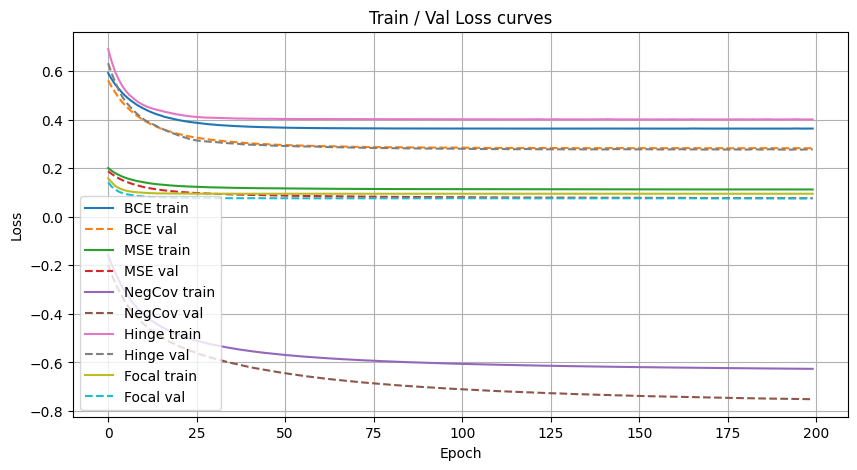

In [ ]:
plt.figure(figsize=(10,5))
for name, (_, history, _) in models_results.items():
    plt.plot(history['train_loss'], label=f'{name} train')
    plt.plot(history['val_loss'],   label=f'{name} val', linestyle='--')
plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.title('Train / Val Loss curves')
plt.legend(); plt.grid(True); plt.show()

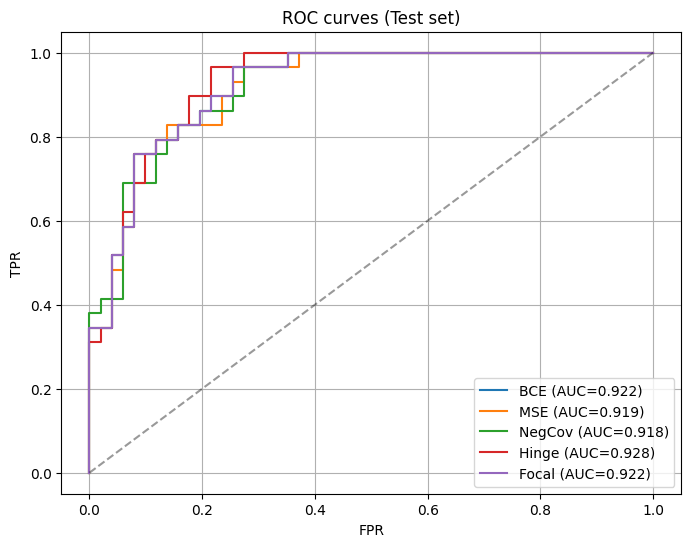

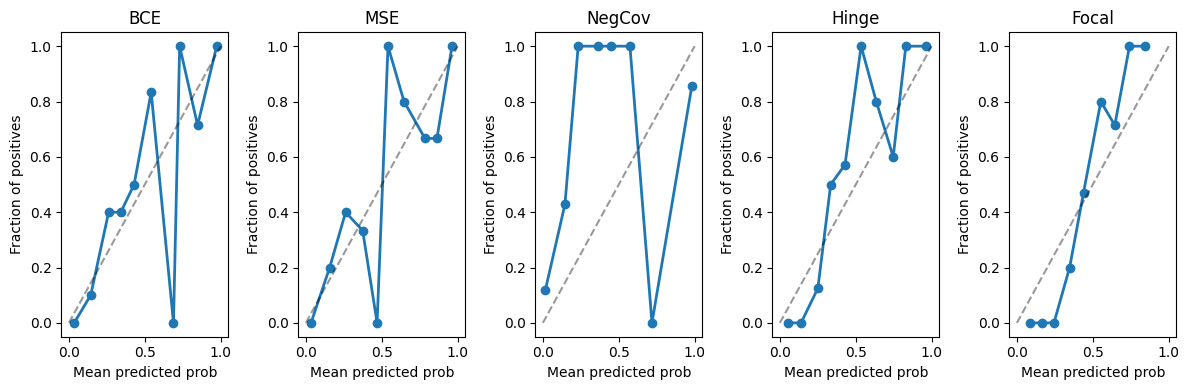

In [ ]:
plt.figure(figsize=(8,6))
for name, (_, _, res) in models_results.items():
    fpr, tpr, _ = roc_curve(res['test']['y_true'], res['test']['probs'])
    auc = res['test']['roc_auc']
    plt.plot(fpr, tpr, label=f'{name} (AUC={auc:.3f})')
plt.plot([0,1],[0,1], 'k--', alpha=0.4)
plt.xlabel('FPR'); plt.ylabel('TPR'); plt.title('ROC curves (Test set)')
plt.legend(); plt.grid(True); plt.show()

# Calibration subplots
plt.figure(figsize=(12,4))
n_bins = 10
for idx, (name, (_, _, res)) in enumerate(models_results.items(), 1):
    plt.subplot(1, len(models_results), idx)
    frac_pos, mean_pred = calibration_curve(res['test']['y_true'], res['test']['probs'], n_bins=n_bins, strategy='uniform')
    plt.plot(mean_pred, frac_pos, marker='o', linewidth=2)
    plt.plot([0,1],[0,1], 'k--', alpha=0.4)
    plt.title(name)
    plt.xlabel('Mean predicted prob'); plt.ylabel('Fraction of positives'); plt.ylim(-0.05,1.05)
plt.tight_layout(); plt.show()

In [ ]:
df_results.to_csv('objective_comparison_results.csv', index=False)
print("Saved summary -> objective_comparison_results.csv")

preds = {'y_true': models_results['BCE'][2]['test']['y_true']}
for name, (_, _, res) in models_results.items():
    preds[f'probs_{name}'] = res['test']['probs']
df_preds = pd.DataFrame(preds)
df_preds.to_csv('objective_comparison_predictions.csv', index=False)
print("Saved test predictions -> objective_comparison_predictions.csv")

# Done

Saved summary -> objective_comparison_results.csv
Saved test predictions -> objective_comparison_predictions.csv
